In [1]:
# Luke McGovern
# cs3110 Data Privacy
# Final Project
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from scipy import stats
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    sigma_sq = 2 * sensitivity**2 * np.log(1.25 / delta) / (epsilon**2)
    return v + np.random.normal(loc=0, scale=np.sqrt(sigma_sq))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

/Users/lukemcgovern/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


For this project, pretend the only columns of the dataset were the ones I used in my implementations. I forgot to remove all of them

In [41]:
df = pd.read_csv("worldcities.csv", delimiter=',')
df_poly = gpd.read_file("world-administrative-boundaries") # used for heat map
df_poly.insert(9, "density", 0)
# grab world data from geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/89/kbmm1jcj1p1dn9sssq_qck0c0000gn/T/ipykernel_50209/634399972.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


---Helper Functions---

In [3]:
# sort dataframe by highest population
def df_sort(df, amount):
    df_sorted = df.sort_values(by="population", ascending=False).head(amount)
    return df_sorted

In [4]:
# use geopandas to convert long and lat to points on map for any dataframe
def df_geo_data(df):
    geometry = gpd.points_from_xy(df.lng, df.lat)
    df_geo = gpd.GeoDataFrame(df, geometry = geometry)
    return df_geo

In [5]:
# generalizes coordinate to given decimal
def generalize_location(coord, l):
    gen_coord = round(coord, l)
    return gen_coord

In [6]:
# add noise to a set of lng, lat coordinates
def noisy_cords(lng, lat, sensitivity, epsilon):
    noisy_lng = laplace_mech(lng, sensitivity, epsilon)
    noisy_lat = laplace_mech(lat, sensitivity, epsilon)
    return noisy_lng, noisy_lat

---Chunk 1---

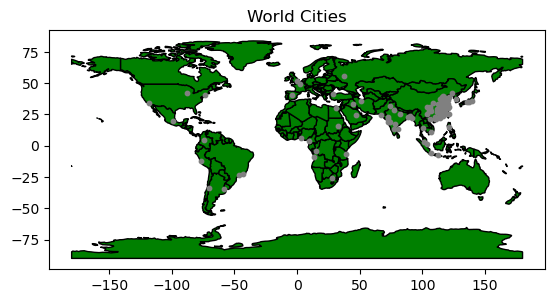

In [18]:
# plot 100 cities on map w/ no privacy
def plot_globe(df):
    df_sorted = df_sort(df, 100) # sort the data to 100 most populous
    df_geo = df_geo_data(df_sorted) # get the points
    # plot on map
    axis = world.plot(color = 'green', edgecolor = 'black')
    df_geo.plot(ax = axis, color = 'gray', markersize=10)
    plt.title('World Cities')
plot_globe(df)

---Chunk 2---

In [19]:
# finds the closest city Point to the given user Point, 
def plot_closest_city(location, cities):
    # convert location pt & city pts into 2 arrays
    loc_arr = np.array(list(location.geometry.apply(lambda x: (x.x, x.y))))
    cit_arr = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    
    # query to find closest city to location
    bTree = cKDTree(cit_arr)
    dist, idx = bTree.query(loc_arr, k=1)
    nearest_city = cities.iloc[idx].drop(columns="geometry").reset_index(drop=True)

    # return city info
    return nearest_city, dist

In [20]:
def deg2rad(degree):
    rad = degree * 2*np.pi / 360
    return(rad)

In [21]:
# convert euclidian distance to km
def compute_dist(x):
    R = 6367 # earth radius
    gamma = 2*np.arcsin(deg2rad(x/(2*R))) # compute the angle of the isosceles triangle (earth's core and 2 Points)
    dist = 2*R*R*np.sin(gamma/2) # compute the side of the triangle
    return(dist)

Closest city to your location: Atlanta, United States
Approximate Distance to Atlanta: 538 km


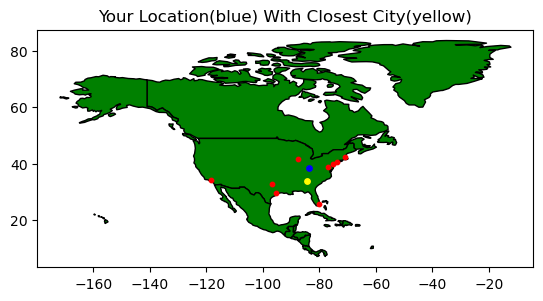

In [27]:
# generalize user data and plot point with cities
def plot_USA_generalized(lng, lat, epsilon):
    df_usa_full = df[(df['country'] == "United States")]
    df_sorted = df_sort(df_usa_full, 10)  # sort by 10 most populous
    df_geo = df_geo_data(df_sorted)  # get the points
    
    # apply noise to coordinates
    noisy_lng, noisy_lat = noisy_cords(lng, lat, 1, epsilon)

    # create dataframe for noisy point
    point_df = pd.DataFrame({'lng': [noisy_lng], 'lat': [noisy_lat]})  
    df_geo_point = df_geo_data(point_df)
    
    closest_city, dist = plot_closest_city(df_geo_point, df_geo)  # find closest city
    dist_km = compute_dist(dist[0])
    df_geo_closest_city = df_geo_data(closest_city)
    
    # plot on map
    axis = world[world.continent == 'North America'].plot(color = 'green', edgecolor = 'black')
    df_geo.plot(ax = axis, color = 'red', markersize=10)  # plot city points
    df_geo_point.plot(ax = axis, color = 'blue', markersize=15)  # plot user point
    df_geo_closest_city.plot(ax = axis, color = 'yellow', markersize=15) # plot closest city
    plt.title('Your Location(blue) With Closest City(yellow)')
    
    print('Closest city to your location: {city}, {country}'.format(city = closest_city.iloc[0].city, 
                                                                    country = closest_city.iloc[0].country))
    print('Approximate Distance to {city}: {dist:.0f} km'.format(city = closest_city.iloc[0].city,
                                                         dist = dist_km))
user_lng, user_lat = -83.756233, 36.652580 # user location
plot_USA_generalized(user_lng, user_lat, 1.0)

---Chunk 3---

Longitude %Error: 2.39
Latitude %Error: 0.19


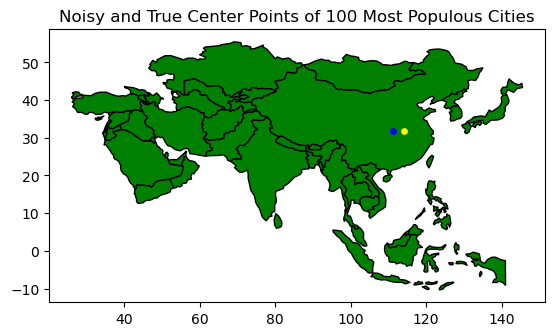

In [37]:
# generate center point of all the cities in Australia
def center_point(epsilon, delta):
    df_china_full = df[(df['country'] == "China")]
    df_sorted = df_sort(df_china_full, 100)
    
    # true lng and lat sums
    true_lng_sum = np.sum(df_sorted.lng)
    true_lat_sum = np.sum(df_sorted.lat)
    # noisy lng and lat sums
    sensitivity = np.sqrt(len(df_sorted))
    noisy_lng_sum = gaussian_mech(np.sum(df_sorted.lng), sensitivity, epsilon/3, delta)
    noisy_lat_sum = gaussian_mech(np.sum(df_sorted.lat), sensitivity, epsilon/3, delta)
    
    # true lng and lat centers
    true_center_lng = true_lng_sum / len(df_sorted)
    true_center_lat = true_lat_sum / len(df_sorted)
    # noisy lng and lat centers
    noisy_len = laplace_mech(len(df_sorted), 1, epsilon/3)
    noisy_center_lng = noisy_lng_sum / noisy_len
    noisy_center_lat = noisy_lat_sum / noisy_len
    
    # create dataframe for noisy and true points for graphing
    true_point_df = pd.DataFrame({'lng': [true_center_lng], 'lat': [true_center_lat]}) 
    noisy_point_df = pd.DataFrame({'lng': [noisy_center_lng], 'lat': [noisy_center_lat]}) 
    
    df_geo_center_true = df_geo_data(true_point_df)
    df_geo_center_noisy = df_geo_data(noisy_point_df)
    
    # plot on map
    axis = world[world.continent == 'Asia'].plot(color = 'green', edgecolor = 'black')
    df_geo_center_true.plot(ax = axis, color = 'yellow', markersize=15) # true center
    df_geo_center_noisy.plot(ax = axis, color = 'blue', markersize=15)  # noisy center
    plt.title('Noisy and True Center Points of 100 Most Populous Cities')
    
    lng_error = pct_error(true_center_lng, noisy_center_lng) # get percent errors
    lat_error = pct_error(true_center_lat, noisy_center_lat)
    print('Longitude %Error: {lng_err:.2f}'.format(lng_err = lng_error))
    print('Latitude %Error: {lat_err:.2f}'.format(lat_err = lat_error))
    
center_point(1.0, 1e-5)

---Chunk 4---

country
Afghanistan    1
Algeria        4
Andorra        1
Angola         3
Argentina      8
              ..
Uruguay        1
Uzbekistan     5
Venezuela      3
Vietnam        6
Zambia         2
Length: 135, dtype: int64


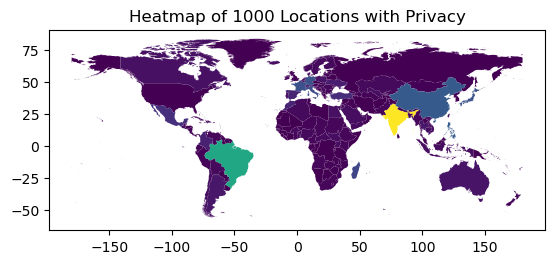

In [46]:
# pretend cities are people's locations, create differentially private heatmap of points by lng and lat chunks
def heat_map(epsilon):
    df_random_loc = df.sample(n=1000)
    # apply noise to locations
    heat_map = df_random_loc.groupby('country').size()
    print(heat_map)
    noisy_heat_map = laplace_mech(heat_map, 1, epsilon)
    
    for ctry, den in noisy_heat_map.items():
        for idx, row in df_poly.iterrows():
            if ctry == row[3]:
                df_poly.at[idx, 'density'] = den
                break
    noisy_heat_map = laplace_mech(heat_map, 10, epsilon)

    
    df_poly.plot(column = 'density') # true center
    plt.title('Heatmap of 1000 Locations with Privacy')
    
heat_map(1.0)